In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_path = "/kaggle/input/animals10/raw-img"

# Load and split the dataset (80% train, 20% val)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


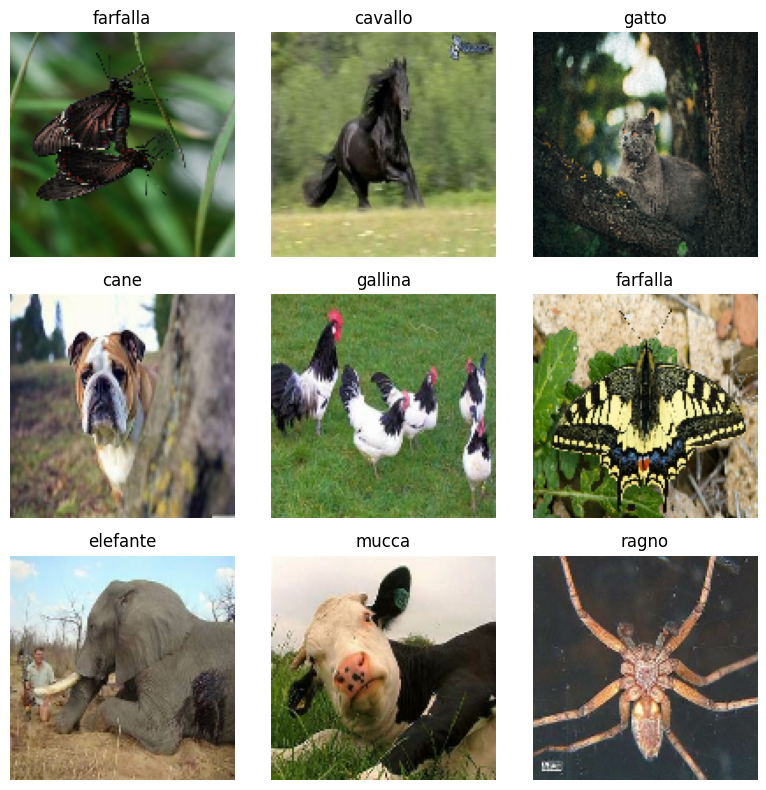

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Clip and normalize the image
        image = images[i].numpy()
        if image.dtype in [np.float32, np.float64]:
            image = np.clip(image, 0, 255) / 255.0

        plt.imshow(image)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

plt.tight_layout()
plt.show()


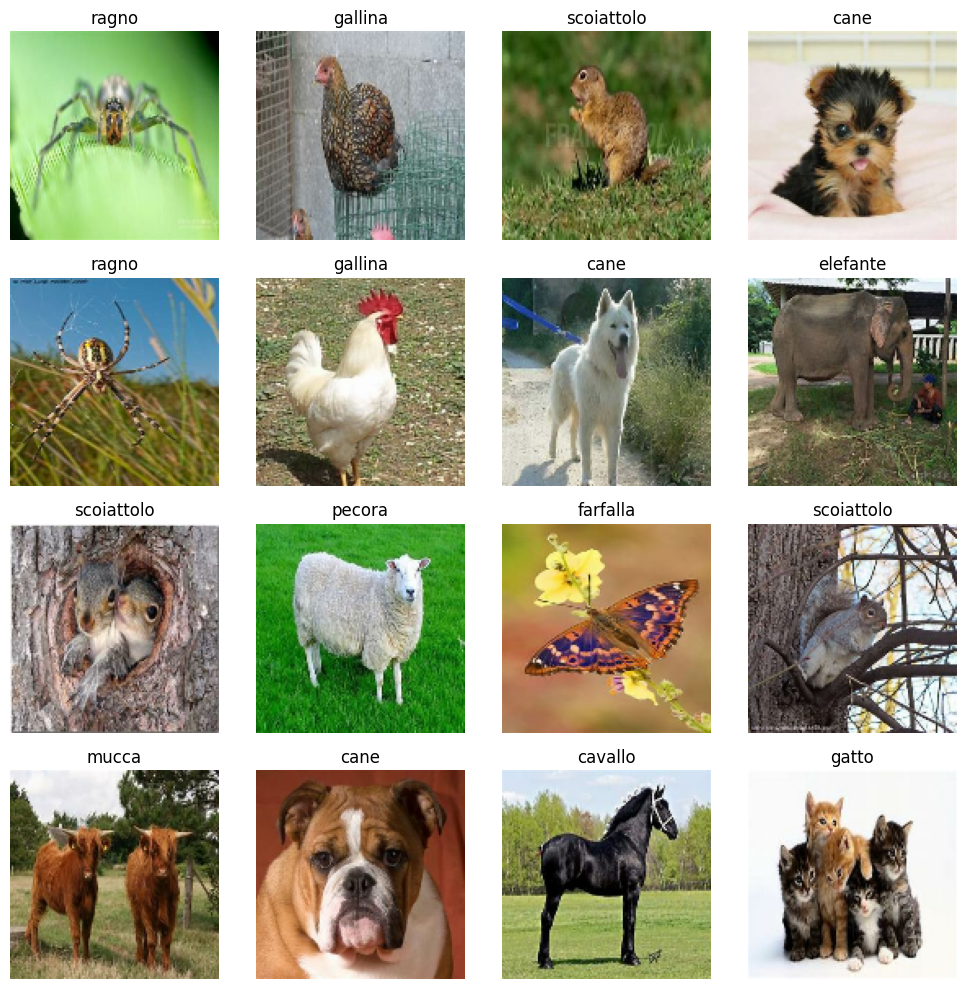

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

sample_ds = train_ds.unbatch().shuffle(1000).batch(16).take(1)

plt.figure(figsize=(10, 10))
for images, labels in sample_ds:
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)

        # Normalize image: clip to [0,255] then scale to [0,1]
        image = images[i].numpy()
        if image.dtype in [np.float32, np.float64]:
            image = np.clip(image, 0, 255) / 255.0

        plt.imshow(image)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))




In [7]:

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.90:
            self.model.stop_training = True
            print("\nReached 90% validation accuracy. Stopping training!")

In [8]:
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:

model = create_cnn_model()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[EarlyStoppingCallback()]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 109ms/step - accuracy: 0.3171 - loss: 1.9249 - val_accuracy: 0.5419 - val_loss: 1.3482
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5836 - loss: 1.2415 - val_accuracy: 0.6214 - val_loss: 1.1246
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.6806 - loss: 0.9499 - val_accuracy: 0.6544 - val_loss: 1.0590
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7636 - loss: 0.6997 - val_accuracy: 0.6468 - val_loss: 1.1620
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.8379 - loss: 0.4753 - val_accuracy: 0.6636 - val_loss: 1.2574
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.8944 - loss: 0.3136 - val_accuracy: 0.6371 - val_loss: 1.5107
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.9303 - loss: 0.2062 - val_accuracy: 0.6529 - val_loss: 1.8226
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9549 - loss: 0.1412 -

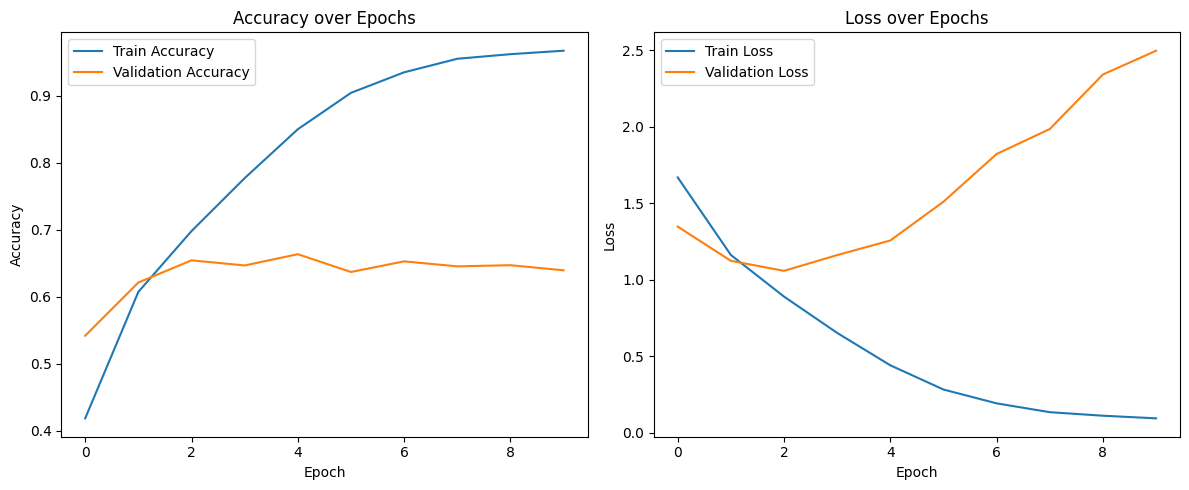

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
translation = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Prediction for: /kaggle/input/animals10/raw-img/cane/OIP-6p-HHjhphvPW9vf63Gg_jAHaGQ.jpeg
dog: 99.79%
cat: 0.21%
chicken: 0.00%


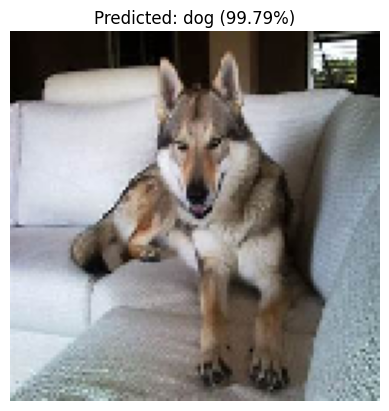

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os # Import the os module

def predict_image(img_path, model, class_names, target_size=(128, 128), top_k=3):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_arr = tf.keras.utils.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    probs = model.predict(img_arr)[0]
    top_indices = probs.argsort()[-top_k:][::-1]

    print(f"\nPrediction for: {img_path}")
    for i in top_indices:
        class_it = class_names[i]
        class_en = translation[class_it]
        print(f"{class_en}: {probs[i]*100:.2f}%")

    plt.imshow(tf.keras.utils.array_to_img(img_arr[0]))
    plt.axis('off')
    plt.title(f"Predicted: {translation[class_names[top_indices[0]]]} ({probs[top_indices[0]]*100:.2f}%)")
    plt.show()

# ---- use it ----
# Use an example image from the dataset
example_image_dir = "/kaggle/input/animals10/raw-img/cane" # Use the directory for 'cane' (dog)
example_image_path = os.path.join(example_image_dir, os.listdir(example_image_dir)[0]) # Get the first image in the directory

predict_image(example_image_path, model, class_names, target_size=(128, 128), top_k=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Prediction for: /kaggle/input/animals10/raw-img/pecora/OIP-3l8KAkAiOcJBbJ-68FCBNwHaE9.jpeg
sheep: 97.96%
dog: 1.98%
elephant: 0.05%


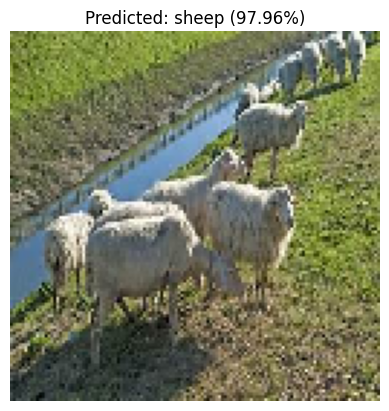

In [16]:
import os # Import the os module

# Use an example image from the dataset (e.g., a sheep image)
example_image_dir = "/kaggle/input/animals10/raw-img/pecora" # Use the directory for 'pecora' (sheep)
example_image_path = os.path.join(example_image_dir, os.listdir(example_image_dir)[0]) # Get the first image in the directory

predict_image(example_image_path, model, class_names, target_size=(128, 128), top_k=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Prediction for: /kaggle/input/animals10/raw-img/scoiattolo/OIP-YFzMgWLbLG9ssDQ-4wdhqwAAAA.jpeg
squirrel: 99.98%
dog: 0.02%
cat: 0.00%


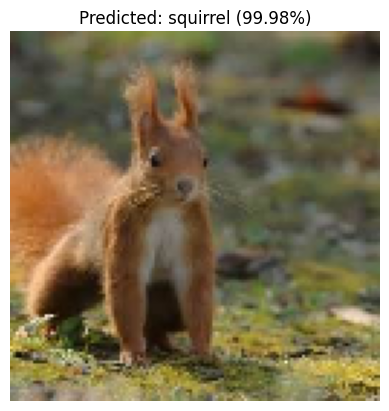

In [18]:
import os # Import the os module

# Use an example image from the dataset
example_image_dir = "/kaggle/input/animals10/raw-img/scoiattolo" # Use the directory for 'scoiattolo' (squirrel)
example_image_path = os.path.join(example_image_dir, os.listdir(example_image_dir)[0]) # Get the first image in the directory

predict_image(example_image_path, model, class_names, target_size=(128, 128), top_k=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Prediction for: /kaggle/input/animals10/raw-img/cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg
horse: 100.00%
cow: 0.00%
dog: 0.00%


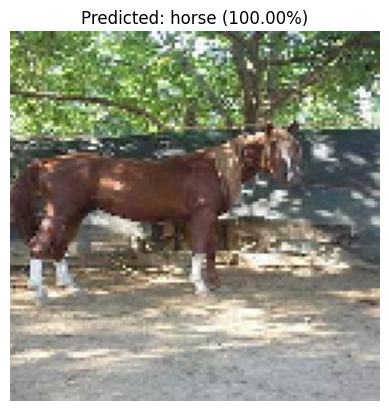

In [20]:
import os # Import the os module

# Use an example image from the dataset
example_image_dir = "/kaggle/input/animals10/raw-img/cavallo" # Use the directory for 'cavallo' (horse)
example_image_path = os.path.join(example_image_dir, os.listdir(example_image_dir)[0]) # Get the first image in the directory

predict_image(example_image_path, model, class_names, target_size=(128, 128), top_k=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Prediction for: /kaggle/input/animals10/raw-img/ragno/OIP-jkRFvLF2qC7bHxf-PLiBTwHaHO.jpeg
spider: 99.99%
cat: 0.00%
butterfly: 0.00%


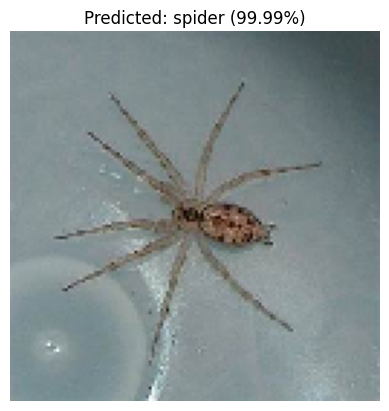

In [22]:
import os # Import the os module

# Use an example image from the dataset
example_image_dir = "/kaggle/input/animals10/raw-img/ragno" # Use the directory for 'ragno' (spider)
example_image_path = os.path.join(example_image_dir, os.listdir(example_image_dir)[0]) # Get the first image in the directory

predict_image(example_image_path, model, class_names, target_size=(128, 128), top_k=3)

In [23]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2%}, Validation Loss: {val_loss:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6401 - loss: 2.5711
Validation Accuracy: 63.95%, Validation Loss: 2.4973


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━

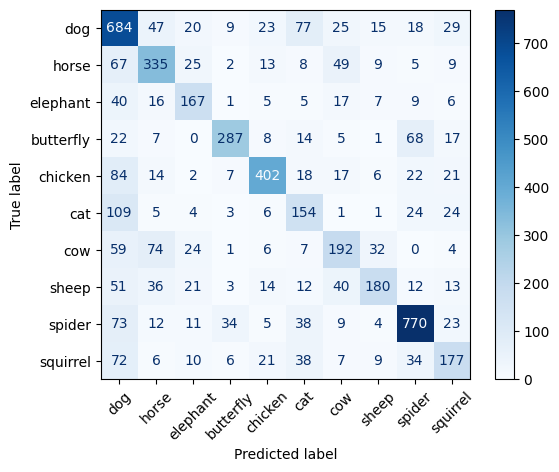

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[translation[c] for c in class_names])
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()